# Pylops - Least squares image-domain migration - marmousi model

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve2D`` operator to perform image-domain least-squares migration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.avo.poststack              import PoststackLinearModelling, PoststackInversion

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

## Model and data creation

Lets' create a model and geometry

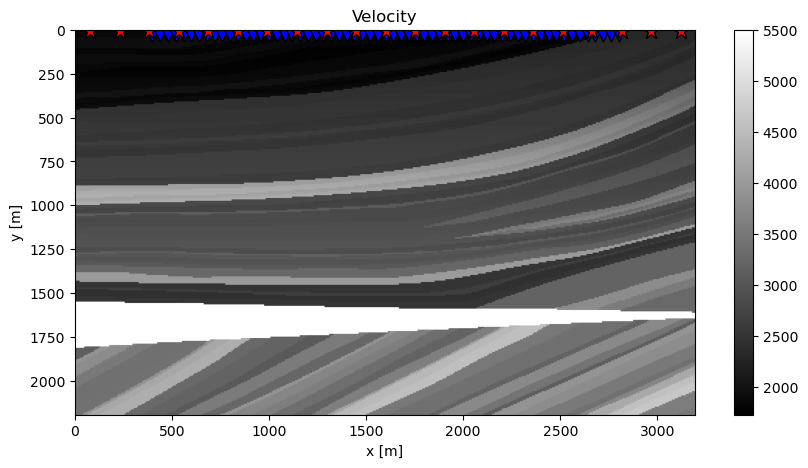

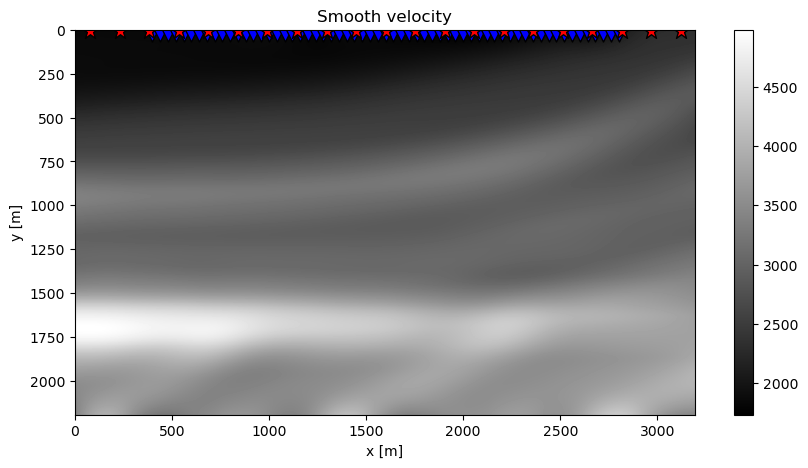

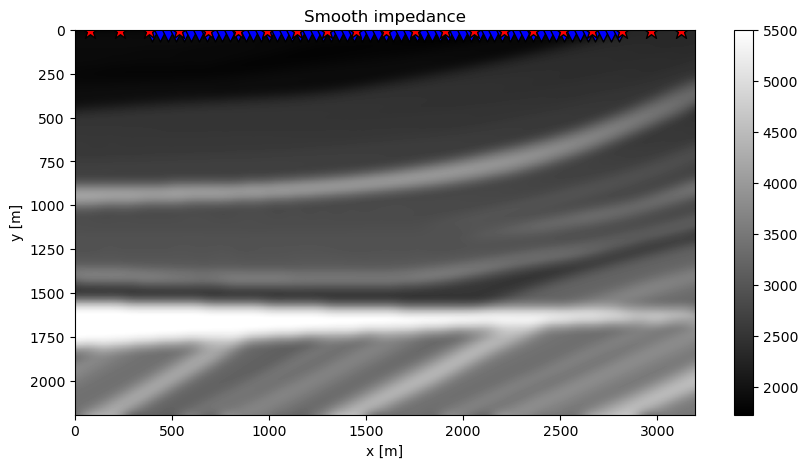

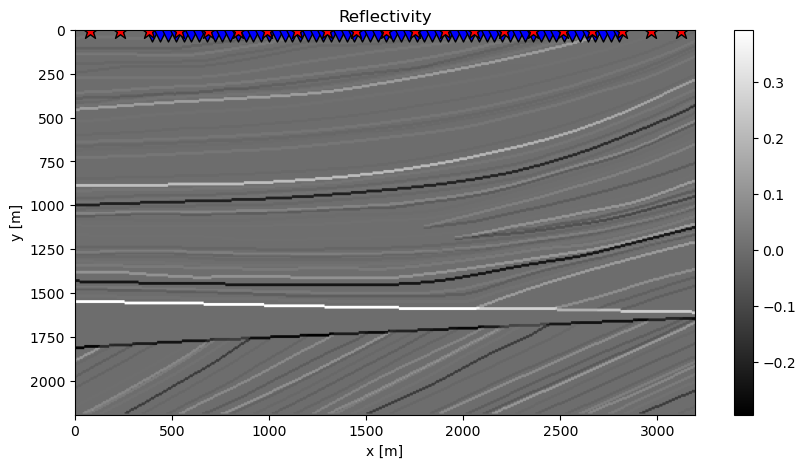

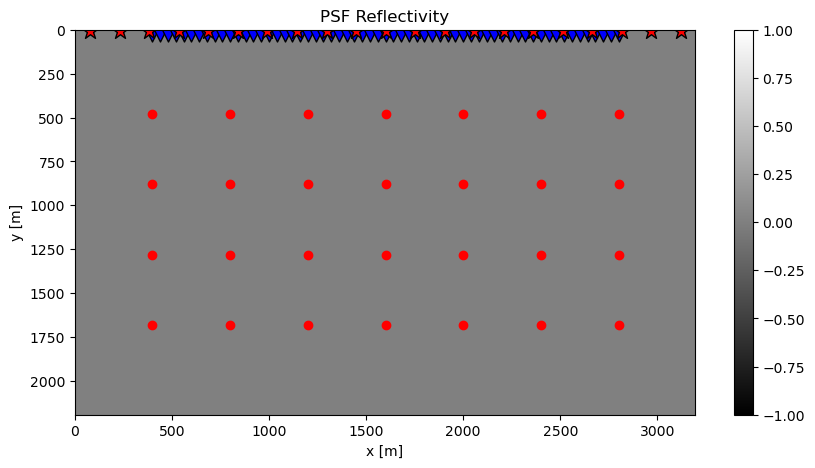

In [2]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
x, z, vel_true = x[::2], z[::2], vel_true[::2, ::2]
nx, nz = len(x), len(z)
dx, dz = x[1]-x[0], z[1]-z[0]

# Impedance
rho = 1.
ip_true = rho * vel_true

# Reflectivity
Dop = FirstDerivative(dims=(nx, nz), axis=1)
refl = Dop * np.log(ip_true)

# PSF Model
psfrefl = np.zeros((nx, nz))
psfin = (50, 60)
psfend = (-49, -49)
psfj = (50, 50)
psfsize = (31, 31)
psfrefl[psfin[0]:psfend[0]:psfj[0], psfin[1]:psfend[-1]:psfj[-1]] = 1

# PSF grid
psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])
Psfx, Psfz = np.meshgrid(psfx, psfz, indexing='ij')

# Smooth velocity
nsmooth = 30
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_sm, axis=1)

# Smooth impedance
nsmooth = 10
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_true, axis=0)
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_sm, axis=1)

# Receivers
nr = 61
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 21
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(ip_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth impedance')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(psfrefl.T, cmap='gray', vmin=-1, vmax=1, extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(Psfx.ravel()*dx, Psfz.ravel()*dz, c='r')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('PSF Reflectivity')
plt.xlim(x[0], x[-1]);

### Dataset creation and migration

In [3]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

kop = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                dynamic=False, wavfilter=True, engine='numba')
kopdyn = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                   dynamic=True, wavfilter=True, aperture=2, angleaperture=50, engine='numba')

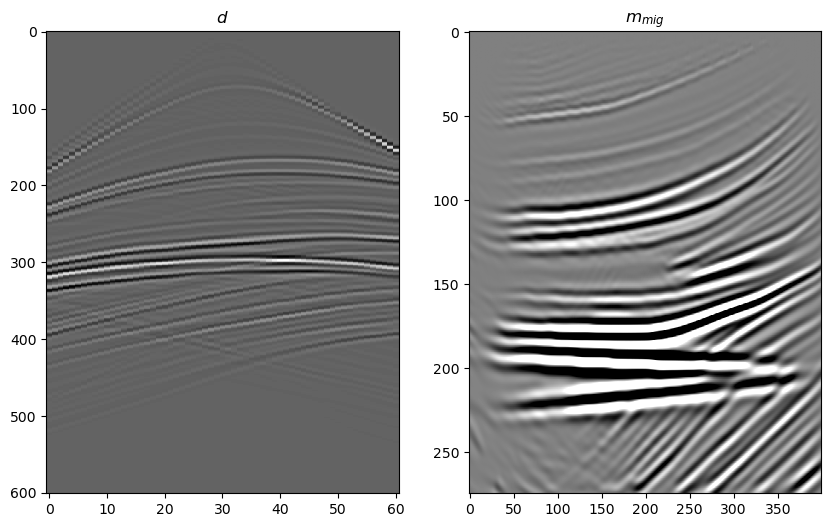

In [4]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)

mmig = kopdyn.H * d.ravel()
mmig = mmig.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(d[ns//2, :, :].T, cmap='gray', interpolation='none')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(mmig.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{mig}$')
axs[1].axis('tight');

### PSF creation and migration

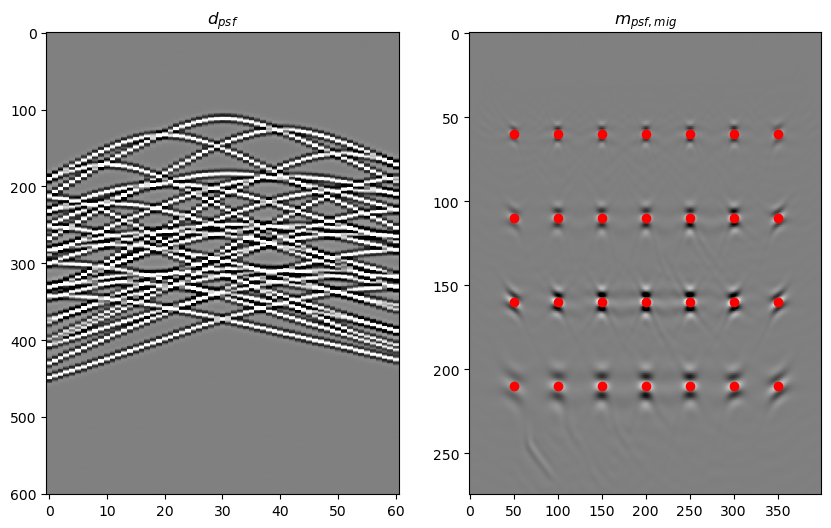

In [5]:
dpsf = kop * psfrefl.ravel()
dpsf = dpsf.reshape(ns, nr, nt)

mmigpsf = kopdyn.H * dpsf.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(dpsf[ns//2, :, :].T, cmap='gray', vmin=-1e2, vmax=1e2, interpolation='none')
axs[0].set_title(r'$d_{psf}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-4, vmax=4)
axs[1].scatter(Psfx.ravel(), Psfz.ravel(), c='r')
axs[1].set_title(r'$m_{psf,mig}$')
axs[1].axis('tight');

## Image domain LSM

First, we extract the different PSFs

In [6]:
psfs = np.zeros((len(psfx), len(psfz), *psfsize))

for ipx, px in enumerate(psfx):
    for ipz, pz in enumerate(psfz):
        psfs[ipx, ipz] = mmigpsf[int(px-psfsize[0]//2):int(px+psfsize[0]//2+1), 
                                 int(pz-psfsize[1]//2):int(pz+psfsize[1]//2+1)] 

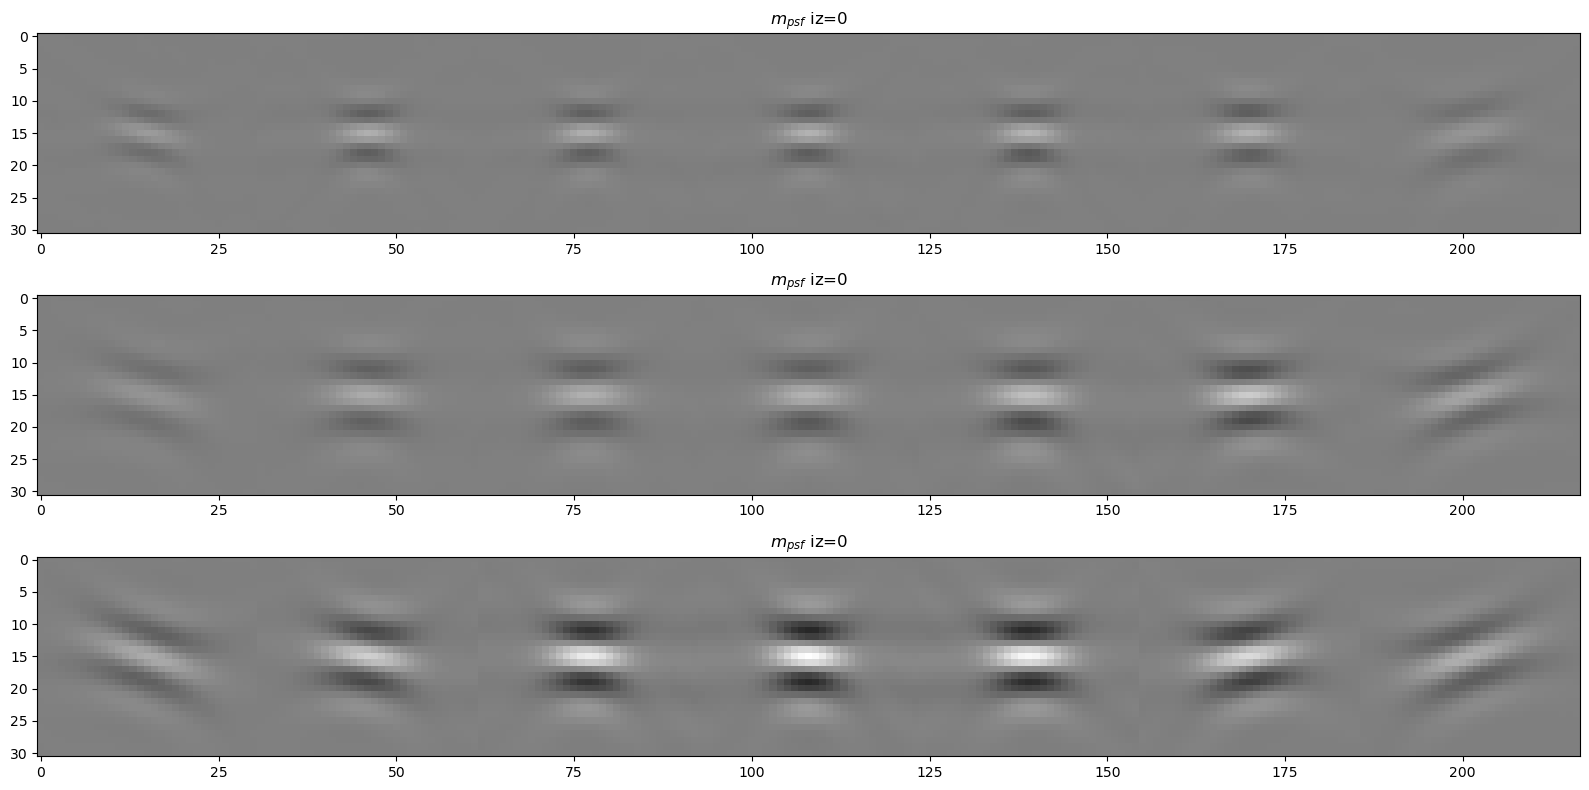

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].imshow(psfs[:, 0].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{psf}$ iz=0')
axs[0].axis('tight')
axs[1].imshow(psfs[:, 1].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{psf}$ iz=0')
axs[1].axis('tight')
axs[2].imshow(psfs[:, 2].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'$m_{psf}$ iz=0')
axs[2].axis('tight')
plt.tight_layout()

In [8]:
Cop = NonStationaryConvolve2D(dims=(nx, nz), hs=psfs, ihx=psfx, ihz=psfz, engine="numba")
Cop_cuda = NonStationaryConvolve2D(dims=(nx, nz), hs=cp.asarray(psfs), ihx=psfx, ihz=psfz, engine="cuda")

mmigforw = Cop * refl
mmigforw_cuda = Cop_cuda * cp.asarray(refl)

mmigadj = Cop.H * mmigforw
mmigadj_cuda = Cop_cuda.H * mmigforw_cuda
np.allclose(mmigforw, mmigforw_cuda), np.allclose(mmigadj, mmigadj_cuda)

(array(False), array(False))

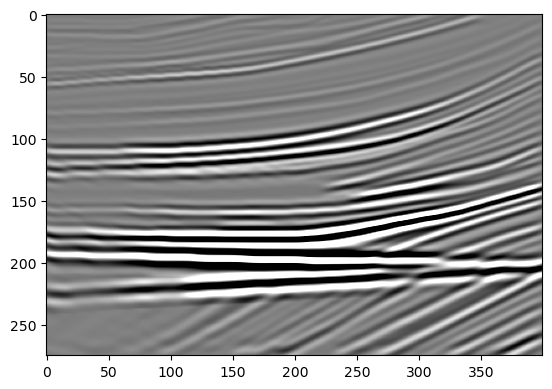

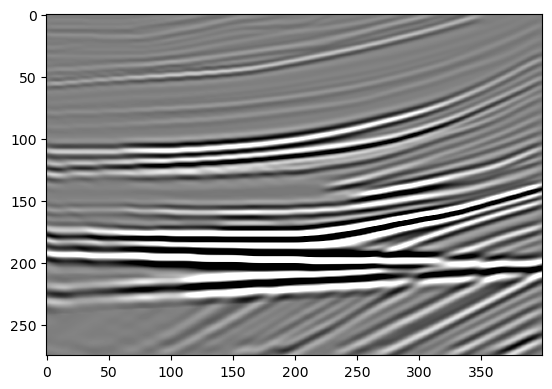

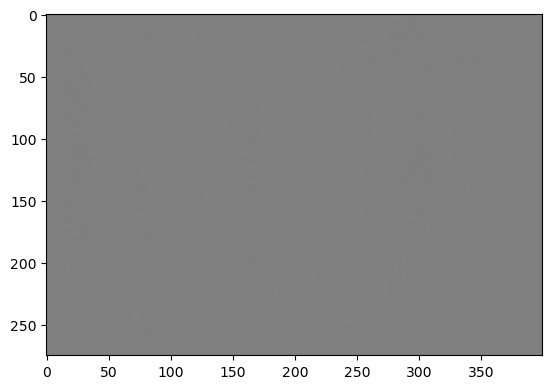

In [9]:
plt.figure()
plt.imshow(mmigforw.T, vmin=-1e1, vmax=1e1, cmap='gray')

plt.figure()
plt.imshow(cp.asnumpy(mmigforw_cuda).T, vmin=-1e1, vmax=1e1, cmap='gray')

plt.figure()
plt.imshow(mmigforw.T-cp.asnumpy(mmigforw_cuda).T, vmin=-1e10, vmax=1e10, cmap='gray');

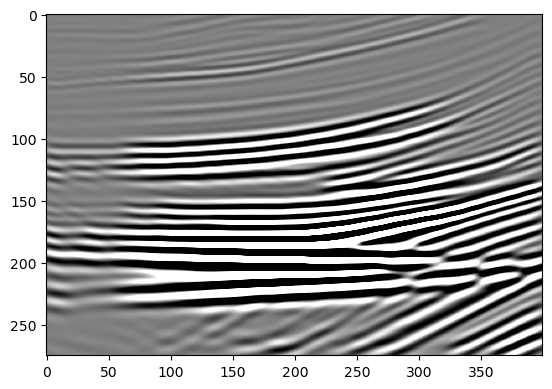

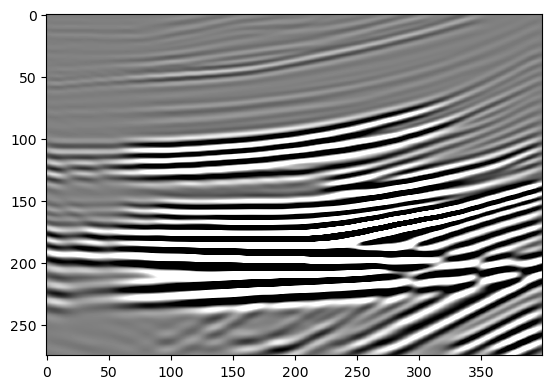

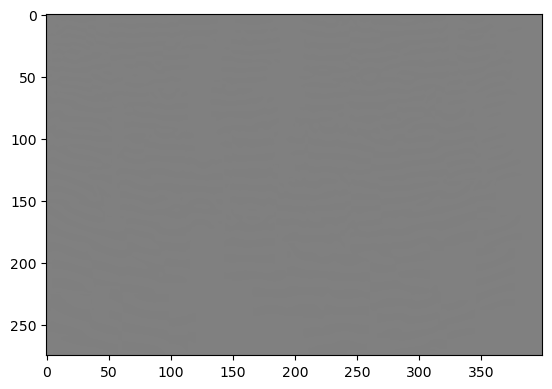

In [10]:
plt.figure()
plt.imshow(mmigadj.T, vmin=-1e3, vmax=1e3, cmap='gray')

plt.figure()
plt.imshow(cp.asnumpy(mmigadj_cuda).T, vmin=-1e3, vmax=1e3, cmap='gray')

plt.figure()
plt.imshow(mmigadj.T-cp.asnumpy(mmigadj_cuda).T, vmin=-1e12, vmax=1e12, cmap='gray');

In [11]:
dottest(Cop, verb=True, raiseerror=False), dottest(Cop_cuda, verb=True, backend="cupy", raiseerror=False);

Dot test failed, v^H(Opu)=16644.507774010614 - u^H(Op^Hv)=16636.333958952957
Dot test passed, v^H(Opu)=-18327.18763676725 - u^H(Op^Hv)=-18327.18763676725


In [12]:
# Timings
x = mmigpsf
xcp = cp.asarray(mmigpsf)

%timeit Cop * x
%timeit Cop_cuda * xcp

%timeit Cop.H * x
%timeit Cop_cuda.H * xcp

37.9 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.17 ms ± 72.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
39.3 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.08 ms ± 80.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Inversion

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
eps = 4.000000e+01	tol = 1.000000e-10	niter = 200
alpha = 4.185446e-06	thresh = 8.370892e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         1.086e+06   1.111e+06   4.505e+00
     2       0.0000e+00         6.407e+05   6.743e+05   1.529e+00
     3       0.0000e+00         4.124e+05   4.536e+05   1.214e+00
     4       0.0000e+00         2.815e+05   3.290e+05   1.017e+00
     5       0.0000e+00         2.016e+05   2.542e+05   8.717e-01
     6       0.0000e+00         1.506e+05   2.077e+05   7.561e-01
     7       0.0000e+00         1.168e+05   1.776e+05   6.623e-01
     8       0.0000e+00         9.330e+04   1.573e+05   5.868e-01
     9       0.0000e+00         7.629e+04   1.430e+05   5.261e-01
    10      

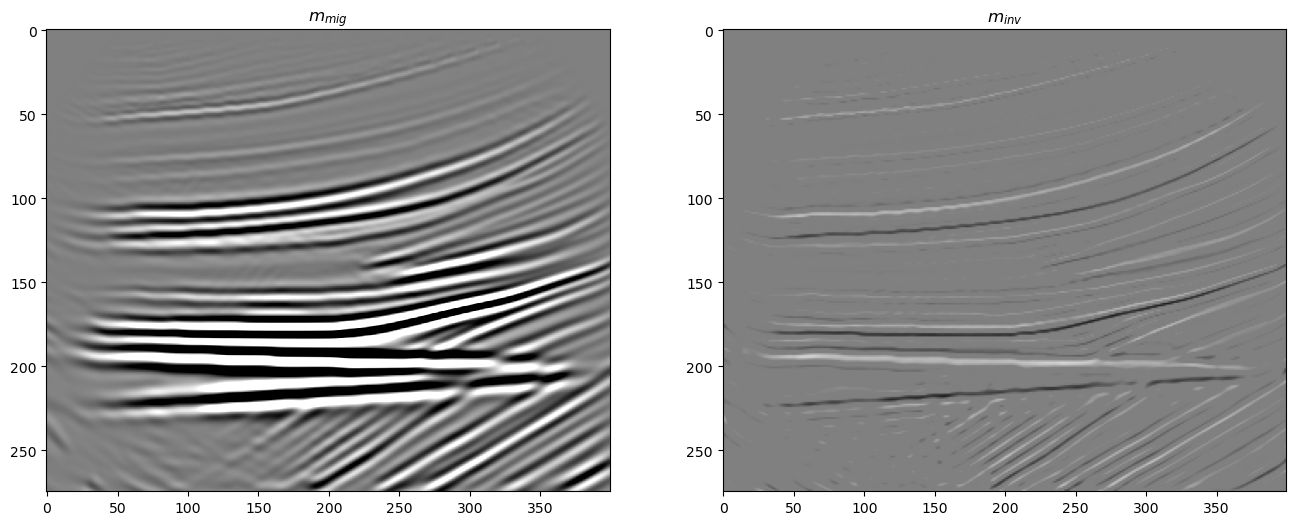

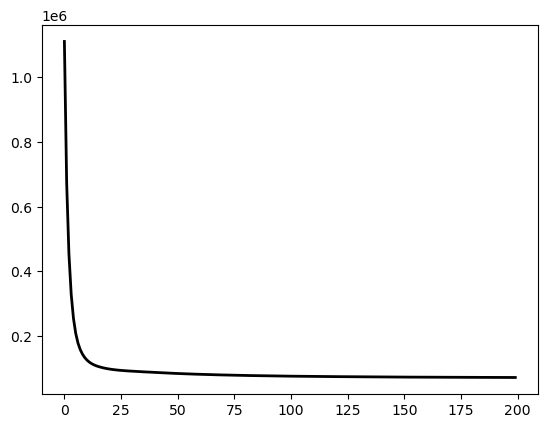

In [13]:
reflinv, _, resnorm = fista(Cop_cuda, cp.asarray(mmig).ravel(), eps=4e1, niter=200, 
                            eigsdict=dict(niter=5, tol=1e-2), show=True)
reflinv = cp.asnumpy(reflinv).reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title(r'$m_{inv}$')
axs[1].axis('tight')

plt.figure()
plt.plot(resnorm, 'k', lw=2);

Let's finally test scalability on a larger model


In [14]:
nx, nz = 3000, 2000

# PSF Model
psfin = (50, 60)
psfend = (-49, -49)
psfj = (50, 50)
psfsize = (31, 31)

# PSF grid
psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])

psfs = np.ones((len(psfx), len(psfz), *psfsize))

Cop = NonStationaryConvolve2D(dims=(nx, nz), hs=psfs, ihx=psfx, ihz=psfz, engine="numba")
Cop_cuda = NonStationaryConvolve2D(dims=(nx, nz), hs=psfs, ihx=psfx, ihz=psfz, engine="cuda")

x = np.ones(Cop.dimsd)
xcp = cp.asarray(x)

%timeit -n3 -r2 Cop * x
%timeit -n3 -r2 Cop_cuda * xcp

%timeit -n3 -r2 Cop.H * x
%timeit -n3 -r2 Cop_cuda.H * xcp

2.37 s ± 172 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
124 ms ± 2.55 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
2.28 s ± 34.4 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
204 ms ± 6.11 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)
